In [1]:
%matplotlib inline

In [2]:
import sys
import os

In [3]:
import numpy as np
from typing import Tuple, List

In [4]:
workspace = os.path.dirname(os.path.abspath("."))
if workspace not in sys.path:
    sys.path.insert(0, workspace)

In [5]:
from amms.uniswap.utils import Token
from amms.uniswap.main import Amm

INFO:uniswap:
CREATED POOL.
x_1, x_2: 99999999999999991611392.0000, 1000000000000000000000.0000.
invariant 9.999999999999999e+43.
ex. rate x_1/x_2 = 0.01.
-------------------------------------



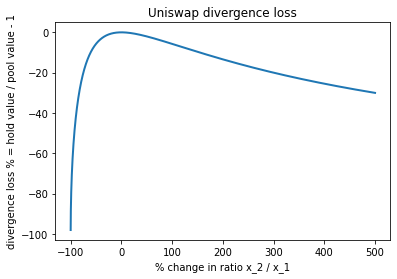

In [6]:
x_1 = Token(1, 100000e18)
x_2 = Token(2, 1000e18)
amm = Amm(x_1, x_2)
_ = amm._plot_divergence_loss()

In [5]:
from amms.balancer.main import plot_divergence_loss, divergence_loss, plot_3d_divergence_loss_2_assets, plot_comparison_divergence_loss

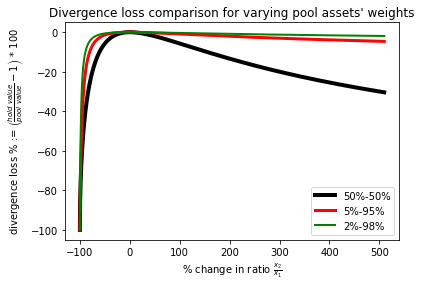

In [7]:
pct_changes = [[0, i] for i in np.arange(-1.0, 5.1, 0.0025)]
plot_comparison_divergence_loss([[0.5, 0.5], [0.05, 0.95], [0.02, 0.98]], pct_changes)

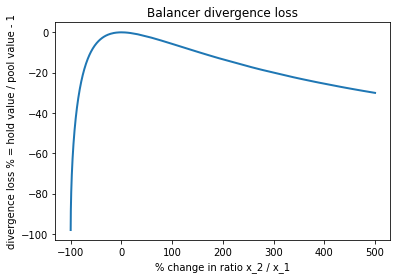

In [9]:
pct_changes = [[0, i] for i in np.arange(-0.9999, 5.0001, 0.0001)]
_ = plot_divergence_loss([0.5, 0.5], pct_changes)

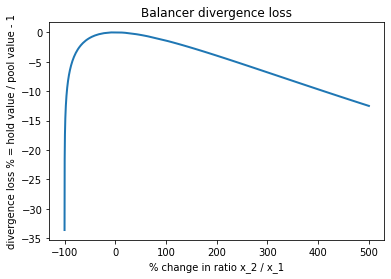

In [12]:
pct_changes = [[0, i] for i in np.arange(-0.9999, 5.0001, 0.0001)]
_ = plot_divergence_loss([0.95, 0.05], pct_changes)

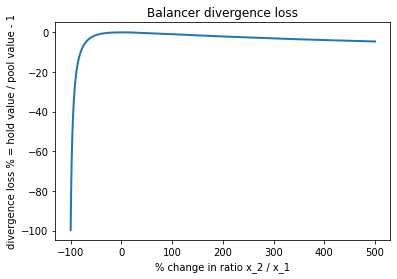

In [13]:
pct_changes = [[0, i] for i in np.arange(-0.9999, 5.0001, 0.0001)]
_ = plot_divergence_loss([0.05, 0.95], pct_changes)

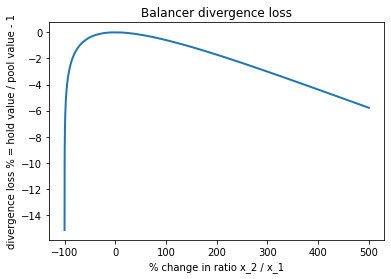

In [16]:
pct_changes = [[0, i] for i in np.arange(-0.9999, 5.0001, 0.0001)]
_ = plot_divergence_loss([0.98, 0.02], pct_changes)

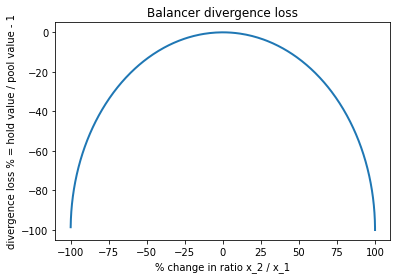

In [21]:
pct_changes = [[-i, i] for i in np.arange(-0.9999, 5.0001, 0.0001)]
# x domain represents the percentage change in asset 2
# for asset 1, the percentage change is -1 * that of asset 2
_ = plot_divergence_loss([0.5, 0.5], pct_changes)

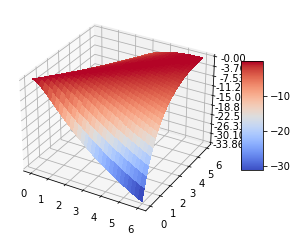

In [8]:
pct_changes_asset_1 = np.arange(-1, 5.1, 0.1)
pct_changes_asset_2 = np.arange(-1, 5.1, 0.1)

plot_3d_divergence_loss_2_assets([0.5, 0.5], pct_changes_asset_1, pct_changes_asset_2)

$$An^n \sum R_j + D = An^nD + \frac{D^{n+1}}{n^n \prod R_j}$$

$$An^n D + D = An^nD + \frac{D^{n+1}}{n^n \prod R_j}$$

$$An^n + 1 = An^n  + \frac{D^n}{n^n \prod R_j}$$

$$1 = \frac{D^n}{n^n \prod R_j}$$

$$1 = \frac{n^n \prod R_j}{D^n}$$

$$D^n = n^n \prod R_j$$

$$\left(\frac{D}{n}\right)^n = \prod R_j$$

for assets when the price is equal. Reduces to balancer's generalised constant product equation

$$An^n \sum R_j + D = An^nD + \frac{D^{n+1}}{n^n \prod R_j}$$

From the YieldSpace paper [https://yield.is/yieldspace.pdf]

$$\chi k (x + y) + xy = \chi k^2 + \frac{k^2}{4}$$

$$\chi k x +\chi k  y + xy = \chi k^2 + \frac{k^2}{4}$$

$$x(\chi k + y) +\chi k  y = \chi k^2 + \frac{k^2}{4}$$

$$x(\chi k + y) = \chi k^2 + \frac{k^2}{4} - \chi k  y$$

$$x = (\chi k^2 + \frac{k^2}{4} - \chi k  y) / (\chi k + y)$$

![curve](./curve_2_asset_constant_chi.png)

In [29]:
# @param reserves - denotes current state of coin reserves
def get_dy(reserves: List[float], ix_in_and_qty: Tuple[int, float]):
    if not len(reserves) == 2:
        raise Exception("invalid len")
    if not len(ix_in_and_qty) == 2:
        raise Exception("incorrect amt of args")
    ix_in, qty = ix_in_and_qty
    if not qty > 0:
        raise Exception("invalid qty in")
    if not ix_in < len(reserves):
        raise Exception("invalid ix in")
    if not ix_in >= 0:
        raise Exception("invalid ix in")

    amplification = 85

    prev_k = reserves[0] * reserves[1]
    new_asset_i = reserves[ix_in] + qty
    new_asset_j = (amplification * prev_k ** 2 + (prev_k ** 2) / 4 - amplification * prev_k * new_asset_i) / (amplification * prev_k * new_asset_i)
    ix_out = 1 if ix_in == 0 else 0
    old_asset_j = reserves[ix_out]
    return (new_asset_j - old_asset_j, new_asset_j)

def curve_divergence_loss(reserves: List[float], pct_change: float):
    if not pct_change >= -1:
        raise Exception("invalid percent change")

    current_exchange_rate = reserves[1] / reserves[0]
    new_exchange_rate = (1 + pct_change) * current_exchange_rate
    value_if_held = reserves[0] + reserves[1] / new_exchange_rate
    amplification = 85
    prev_k = reserves[0] * reserves[1]

    discriminant = (amplification * prev_k * (1 + new_exchange_rate)) ** 2 + 4 * new_exchange_rate * (prev_k ** 2) * (amplification + 0.25)
    numerator = - amplification * prev_k * (1 + new_exchange_rate) # always -ve
    denominator = 2 * new_exchange_rate
    # new_asset_i = (numerator - np.sqrt(discriminant)) / denominator
    new_asset_i = (numerator + np.sqrt(discriminant)) / denominator
    print("new_asset_i", new_asset_i)
    new_asset_j = (amplification * (prev_k ** 2) + (prev_k ** 2 / 4) - amplification * prev_k * new_asset_i) / (amplification * prev_k + new_asset_i)

    value_of_pool = new_asset_i + new_asset_j / new_exchange_rate

    _divergence_loss = value_of_pool / value_if_held - 1

    return _divergence_loss

$$x = (\chi k^2 + \frac{k^2}{4} - \chi k  y) / (\chi k + y)$$

In [30]:
get_dy([1_000, 1_000], [0, 100])

(-89.23529411764707, 910.7647058823529)

In [33]:
curve_divergence_loss([1_000, 1_000], 1)

new_asset_i 333441.699084796


443.58893211306105